# Text Classification with PyTorch - Summary

### Steps - Brief Overview

***Base Text Transformation***

To be able to classify text, we first need to vectorize it. This is usually made with two steps:

- Tokenization: we transform each word or certain group of words into tokens, numerical values

- Embedding: We transform each token into a vector, that represents that token/word. These are then used to create the document level embedding for the entire phrase or text. The process of summarizing each word embedding is made through a sequence model, this can be anything from a function that returns the mean sum of every vector to a transformer or even a language model (BERT, for example).

***Classifying Text***

We can use any classification model, but logistic regression is the basis for these processes, being one of the most basic classifiers and easily trainable.


## Sample Dataset

In [17]:
from sklearn.model_selection import train_test_split
import kagglehub
import pandas as pd
import os
from pathlib import Path

path = kagglehub.dataset_download("praveengovi/emotions-dataset-for-nlp")

print(os.listdir(path))
df_train = pd.read_csv(Path(path) / "train.txt", sep=';', names=["Text", "Class"], header=None)
df_test = pd.read_csv(Path(path) / "test.txt", sep=';', names=["Text", "Class"], header=None)

df = pd.concat([df_train, df_test])

X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Class'], test_size=0.2, random_state=42)

['test.txt', 'train.txt', 'val.txt']


## Basic Bag of Words Model - 

This code trains a basic BoW model and prints its accuracy scores.

A Bag of Words (BoW) model is the simplest laguange classification model. It represents each word in a document as a value in a vector that represents the document as a whole. The vectorization process tales away context or order of words. During the classification process, each value gets multiplied by a specific value, creating logits. This means we can classify texts based on the presence or absence of certain words. It also shows how explainable the whole process is. This type of model is easily trainable, as well. 

TFIDF takes the rarity of each specific word into consideration when training and, as a consequence, also when generating the phrase vector.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
# import joblib


pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

# joblib.dump(pipeline, 'test_bow.joblib')

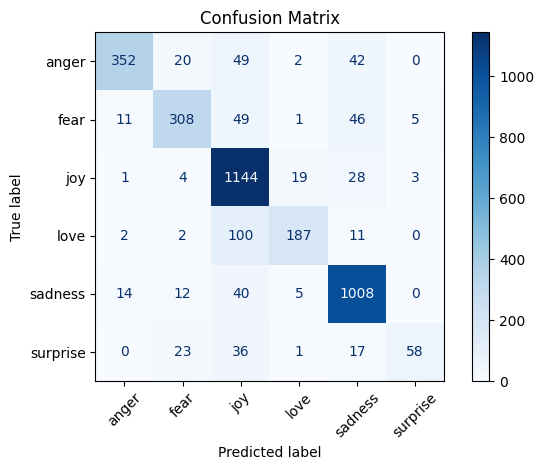

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict using the trained pipeline
y_pred = pipeline.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


## Using Pre-Trained BERT Model

This code implements the same classification steps as with the previous pipeline, but substitutes the TFIDF Vectorizer for a BERT pre-trained model. This gives us document level embeddings based on previous text used in training, meaning we're not limited to vocabulary (words) in our training set, as with the TFIDF Vectorizer.

BERT is trained to be able to predict words missing in texts, this is known as the *cloze* problem. It uses the context around the word (the rest of the phrase) to make its prediction. This makes BERT give dense embeddings for each phrase/document. This also means that words with similar usage or context tend to get similar embeddings. This can sometimes be interpreted and semantic simmilarities between words, only in an Euclidian space. These embeddings also work for words outside its training vocabulary, since the model uses the context to vectorize each word. These embeddings can be used with a Logistic Regression (or any other classifier) to classify texts.  These embeddings are also much harder to interpret, since BERT is a black-box. Also, since BERT is pre-trained, it is limited to its already trained contexts and phrases. Furthermore, it is extremely taxing to train a BERT model from scratch, as it is computationaly expensive, and occupies a much larger space on a hard-drive when compared to a BoW model.

In [ ]:
import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm

class BERTVectorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, model_name='bert-base-uncased'):
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)

    def fit(self, X, y=None):
        return self  # No fitting needed

    def transform(self, X):
        embeddings = []
        for i in tqdm(range(len(X))):
            txt = X.iloc[i]
            encoded_input = self.tokenizer(txt, return_tensors='pt', max_length=512, padding=True, truncation=True)
            output = self.model(**encoded_input)
            embeddings.append(output.last_hidden_state[0,0,:].detach().numpy())
                
        self.embeddings = np.array(embeddings)

        return self.embeddings


b = BERTVectorizer()

embeddings = b.transform(X=df["Text"])

df["embeddings"] = embeddings

X_train, X_test, y_train, y_test = train_test_split(df["embeddings"], df['Class'], test_size=0.2, random_state=42)


pipeline = Pipeline([
    ('logreg', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.50      0.45      0.47       465
        fear       0.50      0.43      0.46       420
         joy       0.67      0.76      0.71      1199
        love       0.37      0.22      0.27       302
     sadness       0.59      0.66      0.62      1079
    surprise       0.40      0.26      0.31       135

    accuracy                           0.59      3600
   macro avg       0.50      0.46      0.48      3600
weighted avg       0.57      0.59      0.57      3600



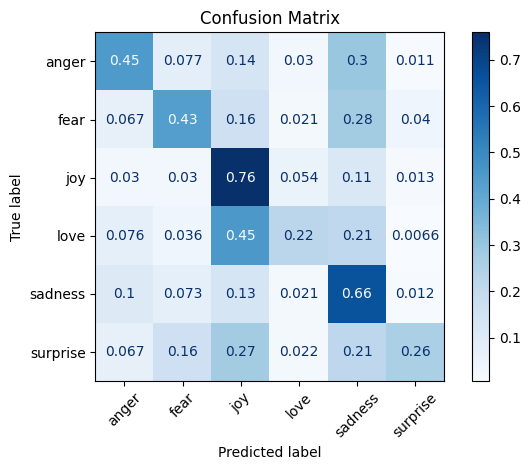

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict using the trained pipeline
y_pred = pipeline.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Convert list-of-vectors column to 2D NumPy array
embeddings_array = np.vstack(df_["embeddings"].values)

# Encode string labels to integers
label_encoder = LabelEncoder()
category_labels = label_encoder.fit_transform(df_["category"])

# Dimensionality reduction
pca = PCA(n_components=2)
embeddings_post_pca = pca.fit_transform(embeddings_array)

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_post_tsne = tsne.fit_transform(embeddings_array)

# Plotting
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(embeddings_post_pca[:, 0], embeddings_post_pca[:, 1], c=category_labels, cmap='tab10')
plt.title("PCA")

plt.subplot(1, 2, 2)
plt.scatter(embeddings_post_tsne[:, 0], embeddings_post_tsne[:, 1], c=category_labels, cmap='tab10')
plt.title("t-SNE")

plt.suptitle("Embedding projections")
plt.tight_layout()
plt.show()